![](images/ohm_logo.png)

<h1><center>Bachelor Thesis</center></h1>

<h1><center><big>IT-based Automatic Text Summarization with the use of Text Generation methods</big><br><hr> <i>State of the art and design of a prototype </i></center></h1>

<center>from Tim Löhr</center>

# 1.0 Importing the Dependcies

In [1]:
from attention import AttentionLayer

import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup

from nltk.corpus import stopwords   
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import backend as K 

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt

import spacy
spacy.load("en")

from sumeval.metrics.rouge import RougeCalculator
from sumeval.metrics.bleu import BLEUCalculator
from nltk.translate.bleu_score import sentence_bleu

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timloehr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2.0 Loading the Data

In [4]:
data = pd.read_csv('amazon-fine-food-reviews/Reviews.csv', nrows=250000)
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...


In [4]:
data.shape

(250000, 10)

# 3.0 Data Preprocessing

In [5]:
data = data[['Summary', 'Text']]

In [6]:
data.drop_duplicates(subset='Text')
data.dropna(axis=0, inplace=True)

In [7]:
data.shape

(249990, 2)

### Contraction Mapping

In [8]:
from contraction_mapping import contraction_mapping

contraction_mapping = contraction_mapping()

## Cleaning

### Text Cleaning

In [9]:
stop_words = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')

def text_cleaner(text):
    newString = text.lower()
    #newString = BeautifulSoup(newString, "lxml").text
    tags = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    newString = tags.sub('', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

#### Cleaned text concatenate with DataFrame

In [10]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

### Summary Cleaning

In [11]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [12]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [13]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_ ' + x + ' _END_')

In [14]:
data.head()

,Summary,Text,cleaned_text,cleaned_summary
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,_START_ good quality dog food _END_
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,_START_ not as advertised _END_
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,_START_ delight says it all _END_
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,_START_ cough medicine _END_
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,_START_ great taffy _END_


### Distribution of the sequences

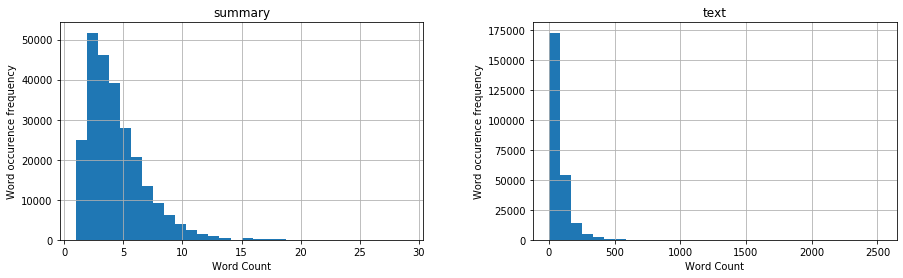

In [22]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['Text']:
      text_word_count.append(len(i.split()))

for i in data['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
axarr = length_df.hist(bins = 30, figsize=(15,4))
for ax in axarr.flatten():
    ax.set_xlabel("Word Count")
    ax.set_ylabel("Word occurence frequency")
plt.show()

In [101]:
max_len_text=80 
max_len_summary=10

### Preparing Tokenizer

In [102]:
X_train , X_test , y_train , y_test = train_test_split(data['cleaned_text'], data['cleaned_summary'], test_size=0.1, random_state=0, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(224814,)
(24980,)
(224814,)
(24980,)


#### Text Tokenizer

In [103]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train = x_tokenizer.texts_to_sequences(X_train) 
X_test = x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train = pad_sequences(X_train,  maxlen=max_len_text, padding='post') 
X_test = pad_sequences(X_test, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1

#### Summary Tokenizer

In [104]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train) 
y_test = y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [105]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(224814, 80)
(24980, 80)
(224814, 10)
(24980, 10)


# 4.0 Model

In [106]:
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

In [107]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      40049500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### Model optimization

In [108]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#### Model fitting

In [109]:
try:
    model = load_model('model.h5', custom_objects={'AttentionLayer': AttentionLayer})
    print("Model successfully loaded.")
except:
    print("Train Model...")
    history = model.fit([X_train, y_train[:,:-1]], 
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=30,
                    callbacks=[es],
                    batch_size=512, 
                    validation_data=([X_test,y_test[:,:-1]],
                                     y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
                   )
    model.save('model.h5')
    print("Model saved")

Train Model...
Train on 224814 samples, validate on 24980 samples
Epoch 1/30
224814/224814 [==============================] - 982s 4ms/sample - loss: 2.8669 - val_loss: 2.4505
Epoch 2/30
224814/224814 [==============================] - 980s 4ms/sample - loss: 2.3291 - val_loss: 2.2047
Epoch 3/30
224814/224814 [==============================] - 979s 4ms/sample - loss: 2.1111 - val_loss: 2.0710
Epoch 4/30
224814/224814 [==============================] - 979s 4ms/sample - loss: 1.9626 - val_loss: 1.9864
Epoch 5/30
224814/224814 [==============================] - 977s 4ms/sample - loss: 1.8385 - val_loss: 1.9306
Epoch 6/30
224814/224814 [==============================] - 976s 4ms/sample - loss: 1.7271 - val_loss: 1.8944
Epoch 7/30
224814/224814 [==============================] - 978s 4ms/sample - loss: 1.6239 - val_loss: 1.8619
Epoch 8/30
224814/224814 [==============================] - 979s 4ms/sample - loss: 1.5275 - val_loss: 1.8335
Epoch 9/30
224814/224814 [============================

# 5.0 Prediction

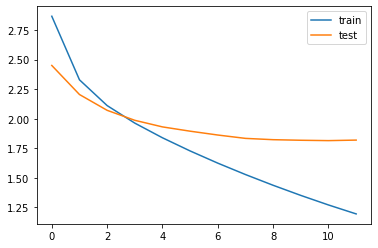

In [110]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend()
plt.show()

In [111]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

#### Inference

In [112]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

#### Inference Process

In [123]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [124]:
def seq2summary(input_seq):
    newString = ''
    
    for i in input_seq:
        if((i!=0 and i!= target_word_index['start']) and i != target_word_index['end']):
            newString = newString + reverse_target_word_index[i] + ' '
            
    return newString

def seq2text(input_seq):
    newString = ''
    
    for i in input_seq:
        if(i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
            
    return newString

In [125]:
for i in range(10):
    print("Review:", seq2text(X_test[i]))
    print("Original summary:", seq2summary(y_test[i]))
    print("Predicted summary:", decode_sequence(X_test[i].reshape(1,max_len_text)))
    print("\n")

Review: already big fan popchips salt vinegar flavor saw coming chili lime flavor excited try flavor disappoint tangy spicy dash sweet new favorite chip never tried popchips aware texture different regular potato chips somewhere traditional chip rice cake throw die hard potato chip fans want something crunchy awesome tasting without many calories fat going new favorite snack 
Original summary: excellent 
Predicted summary:  delicious


Review: ordered chips found salty dry huge amount spices ball one bags opened 
Original summary: too salty and dry 
Predicted summary:  too salty


Review: found tea favorite movie theater found perfect tea guests everyone loves makes love 
Original summary: at the movies and home 
Predicted summary:  love it


Review: dogs special diet treats feed favorites cause problems 
Original summary: must be good 
Predicted summary:  my dogs love these


Review: active lab loves chew really enjoys treats ration gags time usually give treat sitting back porch rela

# 6.0 Evaluation

## 6.1 Rouge Score

In [78]:
rouge = RougeCalculator(stopwords=True, lang="en")

original_summary = ["too salty and dry", "at the movies and home", "must be good", "yummy sweet sherry vinegar", "wrong coffee received"]
predicted_summary = ["too salty", "love it", "my dogs love these", "love these", "coffee received"]

In [109]:
for orig, pred in zip(original_summary, predicted_summary):
    rouge_1 = rouge.rouge_n(summary=orig, references=pred,n=1)

    rouge_2 = rouge.rouge_n(summary=orig, references=pred, n=2)

    rouge_l = rouge.rouge_l(summary=orig, references=pred)

    rouge_be = rouge.rouge_be(summary=orig, references=pred)
    
    print(40*"=")
    print("Original: " + orig)
    print("Predicted: " + pred)
    print("ROUGE-1: {}, ROUGE-2: {}, ROUGE-L: {}, ROUGE-BE: {}".format(rouge_1, rouge_2, rouge_l, rouge_be).replace(", ", "\n"))
    print(40*"=")
    print("\n")

Original: too salty and dry
Predicted: too salty
ROUGE-1: 0.6666666666666666
ROUGE-2: 0
ROUGE-L: 0.6666666666666666
ROUGE-BE: 0


Original: at the movies and home
Predicted: love it
ROUGE-1: 0
ROUGE-2: 0
ROUGE-L: 0
ROUGE-BE: 0


a.dogs=(nsubj)=>love
<BasicElement: dogs-[nsubj]->love>
Original: must be good
Predicted: my dogs love these
ROUGE-1: 0
ROUGE-2: 0
ROUGE-L: 0
ROUGE-BE: 0


Original: yummy sweet sherry vinegar
Predicted: love these
ROUGE-1: 0
ROUGE-2: 0
ROUGE-L: 0
ROUGE-BE: 0


b.wrong=(amod)=>coffee
a.coffee=(nsubj)=>received
<BasicElement: coffee-[nsubj]->receive>
a.coffee=(nsubj)=>received
<BasicElement: coffee-[nsubj]->receive>
Original: wrong coffee received
Predicted: coffee received
ROUGE-1: 0.8
ROUGE-2: 0.6666666666666666
ROUGE-L: 0.8
ROUGE-BE: 0.6666666666666666




## 6.2 BLEU Score

In [110]:
for reference, candidate in zip(original_summary, predicted_summary):

    reference_s = [reference.split()]
    candidate_s = candidate.split()
    
    print(40*"=")
    print("Original: " + reference)
    print("Prediction: " + candidate)
    print('Individual 1-gram: %f' % sentence_bleu(reference_s, candidate_s, weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(reference_s, candidate_s, weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(reference_s, candidate_s, weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(reference_s, candidate_s, weights=(0, 0, 0, 1)))
    print(40*"=")
    print("\n")

Original: too salty and dry
Prediction: too salty
Individual 1-gram: 0.367879
Individual 2-gram: 0.367879
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


Original: at the movies and home
Prediction: love it
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


Original: must be good
Prediction: my dogs love these
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


Original: yummy sweet sherry vinegar
Prediction: love these
Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


Original: wrong coffee received
Prediction: coffee received
Individual 1-gram: 0.606531
Individual 2-gram: 0.606531
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


